# Project title: Binary Classification


#### In this project we will be using the given videos stored in a tensor format that holds 18 different categories of objects inside these videos and also extra information such as the bounding boxes of the objects, coordinates, segmentation masks, depth masks,..etc.

* first we will load the data using the method provided by the professor in the given notebook("project.ipynb").

* then we will divide the videos into frames to facilitate dealing with the data.

* then we will extract the categories of the objects for each frame which will be our labels for the classification task.
* we will explore the data and visualize a sample of it to help us decide which class we will use to apply our Binary Classification task.


* after selecting the class we will use,  we will modify the labels to be 1 for the selected class and 0 for the rest of the classes.


* finally we will apply some preprocessing techniques to prepare the data for the classification task.



## import library

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from skimage.filters import unsharp_mask
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.exposure import equalize_hist
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator

c:\Users\Shenhapy\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## load data

In [2]:
# in this section we will load the data from the tensorflow dataset
tfds.disable_progress_bar()
PROJECT_ROOT_DIR ="E:\OneDrive - University of Ottawa\CV\CV Project"
print(PROJECT_ROOT_DIR)

data_path = os.path.join(PROJECT_ROOT_DIR, 'tensorflow_data')
data_path = os.path.join(data_path, 'tensorflow_data')
os.makedirs(data_path, exist_ok = True)
print("Using directory: ", data_path)

flow_data_set_linear   = tfds.load('elg7186_projectdata/linear_movement_rotate', data_dir=data_path)
flow_data_set_rotation = tfds.load('elg7186_projectdata/rotation_rotate', data_dir=data_path)
flow_data_set_fixed    = tfds.load('elg7186_projectdata/fixed_random_rotate', data_dir=data_path)


E:\OneDrive - University of Ottawa\CV\CV Project
Using directory:  E:\OneDrive - University of Ottawa\CV\CV Project\tensorflow_data\tensorflow_data


In [3]:
def make_df(data_set):
    df_list = []  # Create a list to hold DataFrames
    iter_data = iter(data_set['train'])
    
    for i in range(len(data_set['train'])):
        train_data = next(iter_data)
        video_frames = []
        
        for j in range(len(train_data['video'])):
            video_frames.append({'img': np.array(train_data['video'][j, :, :, :]),
                                 'y': train_data['instances']['category'].numpy()})
        
        df_list.append(pd.DataFrame(video_frames))
    
    return pd.concat(df_list, ignore_index=True)

# Create dataframes for each dataset
df_linear = make_df(flow_data_set_linear)  # 720 frames
df_fixed = make_df(flow_data_set_fixed)    # 720 frames
df_rot = make_df(flow_data_set_rotation)   # 720 frames

# Concatenate the dataframes into one dataframe
df = pd.concat([df_linear, df_fixed, df_rot], ignore_index=True)  # 2160 frames


## make a copy from the dataframe to keep the original one away from modification

In [4]:
import copy
df_copy = copy.deepcopy(df)
df_copy['z'] = df_copy['y'].apply(lambda x: 1 if 14 in x else 0)  # 14 is shoe

# Now the data is ready for the training step

In [5]:
import os

# Define the base directory path
base_dir = "E:/OneDrive - University of Ottawa/CV/CV Project/Data"

# Creating Folders for yolo
# Define the classes (ClassA and ClassB)
classes = ['Shoe', 'No_Shoe']

# Define the split types (train, test, val)
splits = ['train', 'test', 'val']

# Create directories
for split in splits:
    split_dir = os.path.join(base_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    for class_name in classes:
        class_dir = os.path.join(split_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)


In [6]:
from sklearn.model_selection import train_test_split

# Split the data into train, validation, and test sets
train_data, temp_data = train_test_split(df_copy, test_size=0.3, random_state=42, shuffle=True)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

In [7]:
from PIL import Image

# Function to save images in the specified directory
def save_images(data, split_type):
    for index, row in data.iterrows():
        img_array = row['img']
        class_label = row['z']

        class_name = 'Shoe' if class_label == 1 else 'No_Shoe'

        image_filename = f"{class_name}_{index}.jpg"
        image_path = os.path.join(base_dir, split_type, class_name, image_filename)

        image = Image.fromarray(img_array)
        image.save(image_path)

# Save images for train, validation, and test sets
save_images(train_data, 'train')
save_images(val_data, 'val')
save_images(test_data, 'test')


In [143]:
import os

from ultralytics import YOLO


# Load a model
model = YOLO("yolov8n-cls.pt")  # load a pretained model

# Use the model
results = model.train(data=base_dir, epochs=2, imgsz=128)  # train the model

New https://pypi.org/project/ultralytics/8.0.207 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.181  Python-3.11.5 torch-2.0.1+cpu CPU (Intel Core(TM) i7-10700 2.90GHz)
engine\trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=E:/OneDrive - University of Ottawa/CV/CV Project/Data, epochs=2, patience=50, batch=16, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=Non

In [144]:
def plot_confusion_matrix(TP, TN, FP, FN):
    confusion_matrix = np.array([[TP, FP],
                                 [FN, TN]])

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Shoe", "No Shoe"], rotation=45)
    plt.yticks(tick_marks, ["Shoe", "No Shoe"])

    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(confusion_matrix[i, j]), horizontalalignment="center", color="white" if i == j else "black")

    plt.tight_layout()
    plt.show()

In [ ]:
# Load a model
# model = YOLO('yolov8n-cls.pt')  # load an official model
model = YOLO(r"E:\OneDrive - University of Ottawa\CV\CV Project\PreProcess\runs\classify\train4\weights\best.pt")  # load a custom model

# Predict with the model
shoe = model(r"E:\OneDrive - University of Ottawa\CV\CV Project\Data\test\Shoe")  # predict on an image
no_shoe = model(r"E:\OneDrive - University of Ottawa\CV\CV Project\Data\test\No_Shoe")  # predict on an image

In [146]:
counts=[]
for result in shoe:
    probs = result.probs.data.tolist()
    # print(probs)
    index = probs.index(max(probs))
    counts.append(index)
TP = counts.count(1)
FN = counts.count(0)

counts1=[]
for result in no_shoe:
    probs = result.probs.data.tolist()
    # print(probs)
    index = probs.index(max(probs))
    counts1.append(index)
TN = counts1.count(0)
FP = counts1.count(1)

confusion_matrix_data = [[TN, FP], [FN, TP]]

print("TP:",TP)
print("FP:",FP)
print("TN:",TN)
print("FN:",FN)

TP: 166
FP: 0
TN: 157
FN: 1


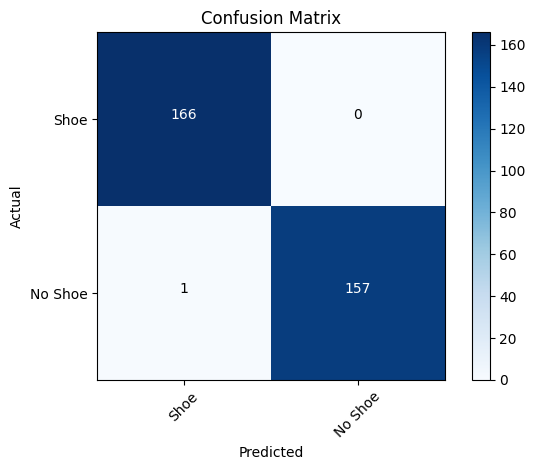

Test Accuracy: 0.9969135802469136
Test Recall: 0.9940119760479041
Test Precision: 1.0
Test F1-score: 0.996996996996997


In [147]:
plot_confusion_matrix(TP, TN, FP, FN)

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Calculate Precision
precision = TP / (TP + FP)

# Calculate Recall
recall = TP / (TP + FN)

# Calculate F1-Score
f1 = (2 * precision * recall) / (precision + recall)

print("Test Accuracy:", accuracy)
print("Test Recall:", recall)
print("Test Precision:", precision)
print("Test F1-score:", f1)